In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import pandas as pd
from pathlib import Path

# ========== CONFIG ==========
dataset_root = "/content/drive/MyDrive/Final Spectrogram/Mel Spectrogram/Spectrogram_10_Sec_trim"
output_root = "/content/drive/MyDrive/Final Spectrogram/Mel Spectrogram/Lebel_Data_10_Sec_trim"
output_image_dir = os.path.join(output_root, "all_images")
output_csv_path = os.path.join(output_root, "labels.csv")
os.makedirs(output_image_dir, exist_ok=True)

valves = ["mitral", "aortic", "tricuspid", "pulmonary"]
splits = ["train", "val", "test"]

records = []

# ========== LOOP ทุก Valve ==========
for valve in valves:
    dataset_path = os.path.join(dataset_root, f"dataset_{valve}")
    for split in splits:
        for label_folder in ["Normal", "Abnormal"]:
            label = 0 if label_folder == "Normal" else 1
            image_dir = os.path.join(dataset_path, split, label_folder)
            if not os.path.exists(image_dir): continue

            for fname in os.listdir(image_dir):
                if not fname.endswith(".png"): continue

                src = os.path.join(image_dir, fname)
                new_fname = f"{valve}_{split}_{label}_{fname}"
                dst = os.path.join(output_image_dir, new_fname)
                shutil.copy(src, dst)

                records.append({
                    "filename": new_fname,
                    "valve": valve,
                    "label": label,
                    "split": split
                })

# ========== SAVE CSV ==========
df = pd.DataFrame(records)
df.to_csv(output_csv_path, index=False)
print(f"✅ Saved labels.csv with {len(df)} records")


KeyboardInterrupt: 

In [4]:
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

valve_to_idx = {"mitral": 0, "aortic": 1, "tricuspid": 2, "pulmonary": 3}

class HeartValveDataset(Dataset):
    def __init__(self, csv_file, image_dir, split, transform=None):
        import pandas as pd
        self.df = pd.read_csv(csv_file)
        self.df = self.df[self.df["split"] == split].reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(image_path).convert("RGB")  # RGB instead of grayscale

        if self.transform:
            image = self.transform(image)

        valve_idx = valve_to_idx[row["valve"]]
        label = torch.tensor([row["label"]], dtype=torch.float32)
        return image, valve_idx, label


In [5]:
import torch.nn as nn
import torch

class MultiValveCNN(nn.Module):
    def __init__(self, num_valves=4):
        super().__init__()
        self.embedding = nn.Embedding(num_valves, 16)  # valve → vector
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),  # Change input channels to 3 (RGB)
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),  # image → feature
            nn.Linear(32 * 56 * 56 + 16, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 1)  # binary output
        )

    def forward(self, x, valve_idx):
        x_feat = self.cnn(x)                         # [B, 32, 56, 56]
        v_feat = self.embedding(valve_idx)           # [B, 16]
        x_feat = torch.flatten(x_feat, 1)            # [B, flat]
        all_feat = torch.cat((x_feat, v_feat), dim=1)
        out = self.fc(all_feat)
        return out


In [15]:
from torchvision import transforms
from torch.utils.data import DataLoader

# ========== CONFIG ==========
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
CSV_PATH = "/content/drive/MyDrive/Final Spectrogram/Mel Spectrogram/Lebel_Data_10_Sec_trim/labels.csv"
IMAGE_DIR = "/content/drive/MyDrive/Final Spectrogram/Mel Spectrogram/Lebel_Data_10_Sec_trim/all_images"

# ========== TRANSFORM ==========
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# ========== LOAD DATA ==========
train_set = HeartValveDataset(CSV_PATH, IMAGE_DIR, split="train", transform=transform)
val_set   = HeartValveDataset(CSV_PATH, IMAGE_DIR, split="val", transform=transform)
test_set  = HeartValveDataset(CSV_PATH, IMAGE_DIR, split="test", transform=transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)


NameError: name 'MultiValveCNN' is not defined

In [17]:
# ตรวจสอบว่า valve_idx เป็น integer และสามารถใช้เป็น index ได้
class_counts = np.array([0] * len(valve_to_idx))  # ตัวแปรนี้จะเก็บจำนวนของแต่ละคลาส
for images, valve_idx, labels in train_loader:
    for idx in valve_idx:
        # ตรวจสอบว่า idx เป็น integer
        if isinstance(idx, int):
            class_counts[idx] += 1  # เพิ่มจำนวนตัวอย่างของแต่ละคลาส
        else:
            print(f"Warning: {idx} is not an integer.")
            # หรืออาจจะทำการแปลงหรือกรองข้อมูลที่ไม่ใช่ integer


In [8]:
MODEL_PATH = "/content/drive/MyDrive/Final Spectrogram/Final Model/Mel-Spectrogram_Data_Pretrain.pt"
torch.save(model.state_dict(), MODEL_PATH)
print(f"💾 Model saved to: {MODEL_PATH}")

💾 Model saved to: /content/drive/MyDrive/Final Spectrogram/Final Model/Mel-Spectrogram_Data_Pretrain.pt


In [9]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import torch

# ===== CONFIG =====
valve_to_idx = {"mitral": 0, "aortic": 1, "tricuspid": 2, "pulmonary": 3}
idx_to_valve = {v: k for k, v in valve_to_idx.items()}

# ===== โหลด CSV อีกครั้งเพื่ออ่าน valve
df_labels = pd.read_csv(CSV_PATH)
df_test = df_labels[df_labels["split"] == "test"].reset_index(drop=True)

# ===== เตรียมเก็บผลลัพธ์
results = {valve: {"y_true": [], "y_pred": []} for valve in valve_to_idx}

model.eval()
with torch.no_grad():
    for images, valve_idx, labels in test_loader:
        images = images.to(device)
        valve_idx = valve_idx.to(device)
        labels = labels.to(device)

        outputs = model(images, valve_idx)
        preds = torch.sigmoid(outputs) > 0.5

        for i in range(len(labels)):
            valve_name = idx_to_valve[valve_idx[i].item()]
            results[valve_name]["y_true"].append(int(labels[i].item()))
            results[valve_name]["y_pred"].append(int(preds[i].item()))


📊 Valve: MITRAL
              precision    recall  f1-score   support

      Normal       0.71      0.48      0.57        25
    Abnormal       0.69      0.85      0.76        34

    accuracy                           0.69        59
   macro avg       0.70      0.67      0.67        59
weighted avg       0.70      0.69      0.68        59



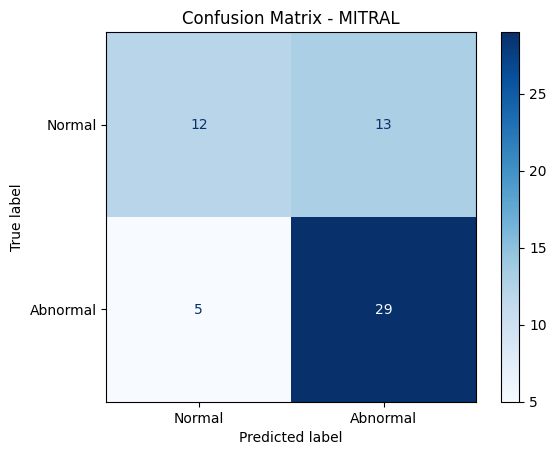

📊 Valve: AORTIC
              precision    recall  f1-score   support

      Normal       0.80      0.48      0.60        25
    Abnormal       0.71      0.91      0.80        35

    accuracy                           0.73        60
   macro avg       0.76      0.70      0.70        60
weighted avg       0.75      0.73      0.72        60



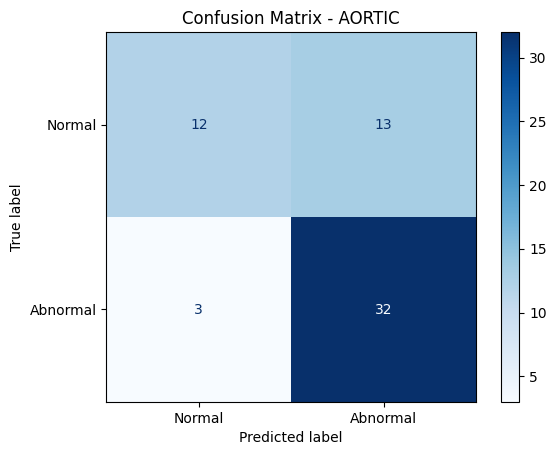

📊 Valve: TRICUSPID
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96        25
    Abnormal       0.78      1.00      0.88         7

    accuracy                           0.94        32
   macro avg       0.89      0.96      0.92        32
weighted avg       0.95      0.94      0.94        32



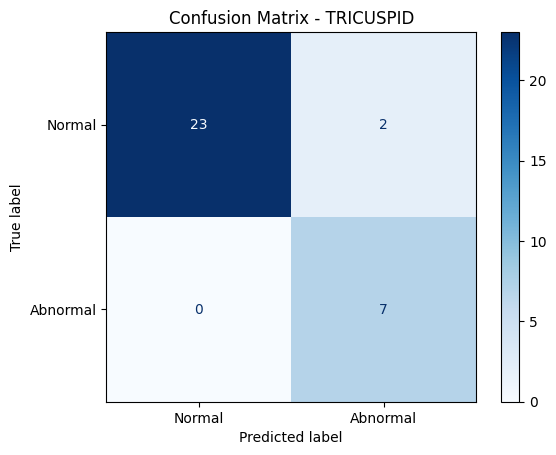

📊 Valve: PULMONARY
              precision    recall  f1-score   support

      Normal       1.00      0.92      0.96        25
    Abnormal       0.71      1.00      0.83         5

    accuracy                           0.93        30
   macro avg       0.86      0.96      0.90        30
weighted avg       0.95      0.93      0.94        30



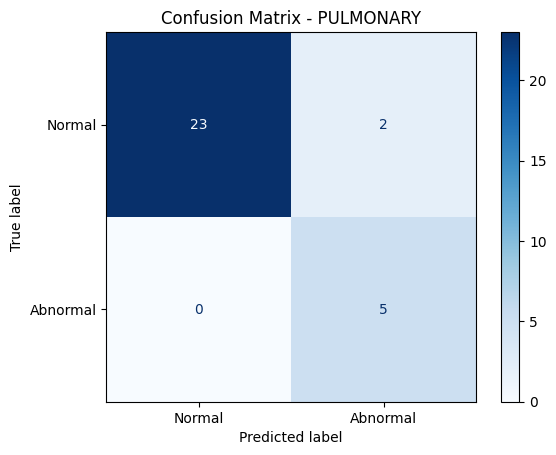

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for valve, data in results.items():
    y_true = data["y_true"]
    y_pred = data["y_pred"]

    print(f"📊 Valve: {valve.upper()}")
    print(classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"], zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {valve.upper()}")
    plt.show()


In [11]:
from sklearn.metrics import accuracy_score

# ===== Accuracy ราย valve =====
for valve, data in results.items():
    acc = accuracy_score(data["y_true"], data["y_pred"])
    print(f"✅ {valve.capitalize()} Accuracy: {acc:.4f}")

# ===== Accuracy รวม =====
all_true = []
all_pred = []

for data in results.values():
    all_true.extend(data["y_true"])
    all_pred.extend(data["y_pred"])

overall_acc = accuracy_score(all_true, all_pred)
print(f"\n🌐 Overall Accuracy (All Valves Combined): {overall_acc:.4f}")


✅ Mitral Accuracy: 0.6949
✅ Aortic Accuracy: 0.7333
✅ Tricuspid Accuracy: 0.9375
✅ Pulmonary Accuracy: 0.9333

🌐 Overall Accuracy (All Valves Combined): 0.7901


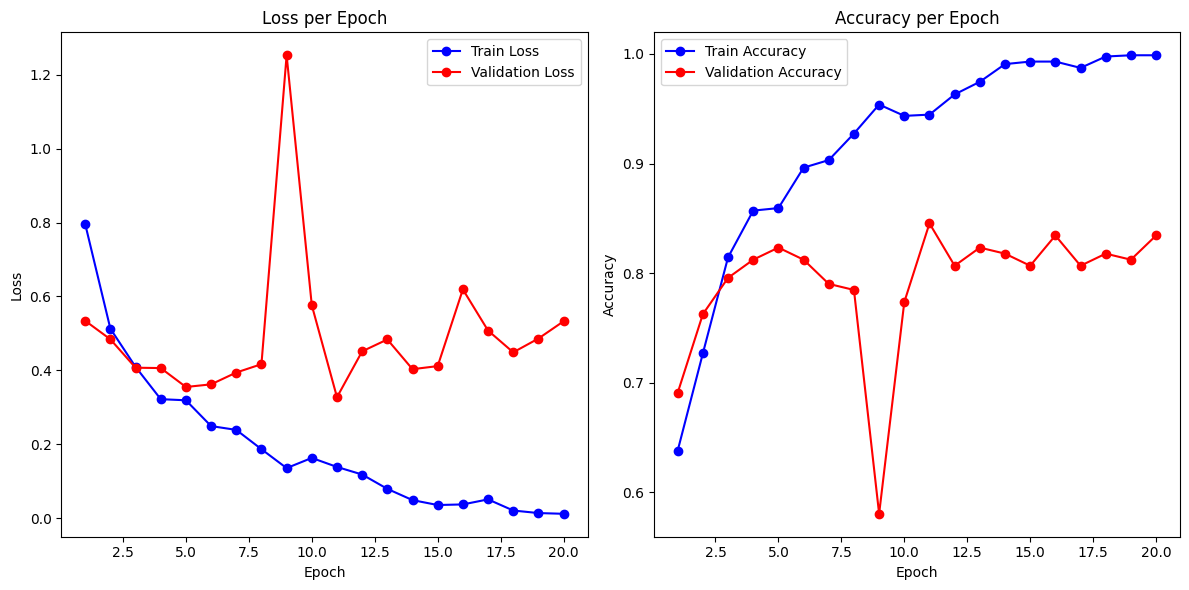

In [12]:
epochs = list(range(1, EPOCHS + 1))

plt.figure(figsize=(12, 6))

# 🔹 Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss', color='blue')
plt.plot(epochs, val_losses, marker='o', label='Validation Loss', color='red')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# 🔹 Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, marker='o', label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy', color='red')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
